In [2]:
import os
import json
import math
import numpy as np
import pandas as pd

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()
sns.set()


## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.utils import save_image
from torchvision.datasets import FashionMNIST
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
from torch.nn.functional import one_hot

from pytorch_fid import fid_score

/tmp/ipykernel_32206/2475230352.py:11: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
/usr/local/lib/python3.10/dist-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The t

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cuda


In [4]:
transform = v2.Compose(
    [
     v2.ToTensor(),
     #v2.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

train_data = ImageFolder('./trafic_32', transform=transform)
train_classes = train_data.classes
train_classes = [name.lstrip('0') if name != '00000' else '0' for name in train_classes]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


In [16]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=256, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)

In [17]:
data, classes = next(iter(train_loader))
classes[0]

tensor(3)

## GAN

In [110]:
NUBMER_OF_CLASSES = 43

In [147]:
class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=16, stride=1, padding=7)
        # self.conv2 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=8, stride=1, padding=4)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=3, kernel_size=4, stride=1, padding=2)

        self.fc_1 = nn.Linear(input_dim + NUBMER_OF_CLASSES, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_out  = nn.Linear(hidden_dim, 1)

        self.LeakyReLU = nn.LeakyReLU(0.2)
        self.bn2d1 = nn.BatchNorm2d(16)
        self.bn2d2 = nn.BatchNorm2d(32)
    def forward(self, x, classes_encoded):
        # x = x.permute(0, 2, 3, 1)
        x = self.conv1(self.LeakyReLU(x))
        x = self.bn2d1(x)
        # x = self.conv2(self.LeakyReLU(x))
        x = self.conv3(self.LeakyReLU(x))
        # print(x.size())
        x = torch.flatten(x, 1)
        x = torch.concat((x, classes_encoded), dim=1)
        # x = x.permute(1, 0)

        x = self.LeakyReLU(self.fc_1(x))
        x = self.LeakyReLU(self.fc_2(x))
        x = self.fc_out(x)
        x = torch.sigmoid(x)
        return x

In [156]:
class Generator(nn.Module):
    def __init__(self, latent_dim, hidden_dim1, hidden_dim2, output_dim):
        super(Generator, self).__init__()
        self.fc_1 = nn.Linear(latent_dim + NUBMER_OF_CLASSES, hidden_dim1)
        self.fc_2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.conv1 = nn.ConvTranspose2d(in_channels=3, out_channels=64, kernel_size=16, stride=1, padding=7)
        self.conv2 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=9, stride=1, padding=4)
        self.conv3 = nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=8, stride=1, padding=4)


        self.fc_4 = nn.Linear(hidden_dim2, output_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim1)
        self.bn2 = nn.BatchNorm1d(hidden_dim2)
        self.bn2d1 = nn.BatchNorm2d(64)
        self.bn2d2 = nn.BatchNorm2d(32)


        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x, classes_encoded):
        h = torch.concat((x, classes_encoded), dim=1)

        h     = self.LeakyReLU(self.fc_1(h))
        h = self.bn1(h)
        h     = self.LeakyReLU(self.fc_2(h))
        h = self.bn2(h)



        x_hat = torch.sigmoid(self.fc_4(h))
        x_hat = x_hat.view([-1, 3, 32, 32])
        x = self.conv1(self.LeakyReLU(x_hat))
        x = self.bn2d1(x)
        x = self.conv2(self.LeakyReLU(x))
        x = self.bn2d2(x)
        x = self.conv3(self.LeakyReLU(x))
        # x = self.conv4(self.LeakyReLU(x))
        # x = torch.flatten(x, 1) # flatten all dimensions except batch
        # x = x.view([-1, 3, 32, 32])
        # x = x.permute(0, 2, 3, 1)
        x = torch.sigmoid(x)

        return x

In [157]:
# Models
latent_dim = 32
generator = Generator(latent_dim=latent_dim, hidden_dim1=128, hidden_dim2=64, output_dim=3072).to(device)
discriminator = Discriminator( hidden_dim=256, input_dim=3072).to(device)

# Optimizers
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0001)
generator_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=generator_optimizer, gamma=0.99)
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0001)
discriminator_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=discriminator_optimizer, gamma=0.99)

# loss
criterion = nn.BCELoss()

In [158]:
def get_classes_encoded(train_classes: list, classes_names: list, encoding):
    return torch.stack([encoding[train_classes.index(str(name.item()))] for name in classes_names], dim=0)

In [159]:
def combine(images, encodings):
    encodings = encodings.unsqueeze(0).unsqueeze(1).unsqueeze(2).unsqueeze(3)
    encodings = encodings.expand(254, 3, 32, 32, 43)

In [160]:
encoding = one_hot(torch.arange(0, 43), 43)

In [161]:
fixed_noise = torch.randn(8, latent_dim,device=device)

In [162]:
G_losses = []
D_losses = []
DF_acc = []
DR_acc = []
num_epochs = 1000

Epoch: 0, discrimiantor fake error: 0.348, discriminator real acc: 0.666


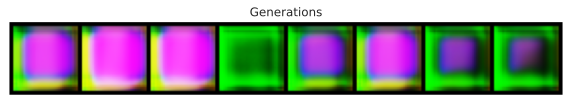

Epoch: 1, discrimiantor fake error: 0.325, discriminator real acc: 0.702
Epoch: 2, discrimiantor fake error: 0.116, discriminator real acc: 0.874
Epoch: 3, discrimiantor fake error: 0.0957, discriminator real acc: 0.911
Epoch: 4, discrimiantor fake error: 0.12, discriminator real acc: 0.897
Epoch: 5, discrimiantor fake error: 0.0967, discriminator real acc: 0.901
Epoch: 6, discrimiantor fake error: 0.147, discriminator real acc: 0.847
Epoch: 7, discrimiantor fake error: 0.0979, discriminator real acc: 0.897
Epoch: 8, discrimiantor fake error: 0.0903, discriminator real acc: 0.917
Epoch: 9, discrimiantor fake error: 0.0953, discriminator real acc: 0.902
Epoch: 10, discrimiantor fake error: 0.071, discriminator real acc: 0.921


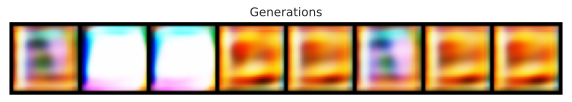

Epoch: 11, discrimiantor fake error: 0.0471, discriminator real acc: 0.939
Epoch: 12, discrimiantor fake error: 0.0536, discriminator real acc: 0.937
Epoch: 13, discrimiantor fake error: 0.0575, discriminator real acc: 0.94
Epoch: 14, discrimiantor fake error: 0.0426, discriminator real acc: 0.961
Epoch: 15, discrimiantor fake error: 0.0506, discriminator real acc: 0.949
Epoch: 16, discrimiantor fake error: 0.0301, discriminator real acc: 0.971
Epoch: 17, discrimiantor fake error: 0.0624, discriminator real acc: 0.939
Epoch: 18, discrimiantor fake error: 0.0479, discriminator real acc: 0.952
Epoch: 19, discrimiantor fake error: 0.0517, discriminator real acc: 0.938
Epoch: 20, discrimiantor fake error: 0.0455, discriminator real acc: 0.948


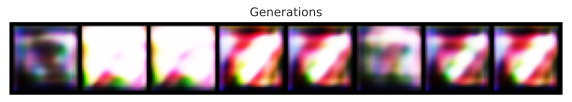

Epoch: 21, discrimiantor fake error: 0.0429, discriminator real acc: 0.956
Epoch: 22, discrimiantor fake error: 0.039, discriminator real acc: 0.961
Epoch: 23, discrimiantor fake error: 0.0532, discriminator real acc: 0.943
Epoch: 24, discrimiantor fake error: 0.0328, discriminator real acc: 0.964
Epoch: 25, discrimiantor fake error: 0.0383, discriminator real acc: 0.96
Epoch: 26, discrimiantor fake error: 0.0498, discriminator real acc: 0.948
Epoch: 27, discrimiantor fake error: 0.0633, discriminator real acc: 0.937
Epoch: 28, discrimiantor fake error: 0.0314, discriminator real acc: 0.968
Epoch: 29, discrimiantor fake error: 0.0201, discriminator real acc: 0.982
Epoch: 30, discrimiantor fake error: 0.0406, discriminator real acc: 0.964


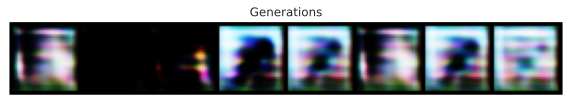

Epoch: 31, discrimiantor fake error: 0.0377, discriminator real acc: 0.963
Epoch: 32, discrimiantor fake error: 0.0376, discriminator real acc: 0.968
Epoch: 33, discrimiantor fake error: 0.0529, discriminator real acc: 0.956
Epoch: 34, discrimiantor fake error: 0.05, discriminator real acc: 0.955
Epoch: 35, discrimiantor fake error: 0.0727, discriminator real acc: 0.929
Epoch: 36, discrimiantor fake error: 0.063, discriminator real acc: 0.944
Epoch: 37, discrimiantor fake error: 0.0475, discriminator real acc: 0.945
Epoch: 38, discrimiantor fake error: 0.0454, discriminator real acc: 0.949
Epoch: 39, discrimiantor fake error: 0.0404, discriminator real acc: 0.953
Epoch: 40, discrimiantor fake error: 0.0657, discriminator real acc: 0.931


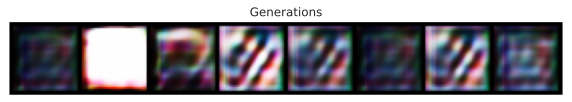

Epoch: 41, discrimiantor fake error: 0.0715, discriminator real acc: 0.919
Epoch: 42, discrimiantor fake error: 0.0614, discriminator real acc: 0.942
Epoch: 43, discrimiantor fake error: 0.0635, discriminator real acc: 0.944
Epoch: 44, discrimiantor fake error: 0.0483, discriminator real acc: 0.957
Epoch: 45, discrimiantor fake error: 0.0596, discriminator real acc: 0.937
Epoch: 46, discrimiantor fake error: 0.0461, discriminator real acc: 0.949
Epoch: 47, discrimiantor fake error: 0.0442, discriminator real acc: 0.956
Epoch: 48, discrimiantor fake error: 0.0425, discriminator real acc: 0.958
Epoch: 49, discrimiantor fake error: 0.0655, discriminator real acc: 0.938
Epoch: 50, discrimiantor fake error: 0.0445, discriminator real acc: 0.953


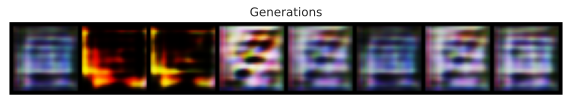

Epoch: 51, discrimiantor fake error: 0.034, discriminator real acc: 0.967
Epoch: 52, discrimiantor fake error: 0.0474, discriminator real acc: 0.948
Epoch: 53, discrimiantor fake error: 0.0372, discriminator real acc: 0.96
Epoch: 54, discrimiantor fake error: 0.0406, discriminator real acc: 0.956
Epoch: 55, discrimiantor fake error: 0.0621, discriminator real acc: 0.943
Epoch: 56, discrimiantor fake error: 0.0554, discriminator real acc: 0.949
Epoch: 57, discrimiantor fake error: 0.0369, discriminator real acc: 0.966
Epoch: 58, discrimiantor fake error: 0.0431, discriminator real acc: 0.961
Epoch: 59, discrimiantor fake error: 0.0476, discriminator real acc: 0.959
Epoch: 60, discrimiantor fake error: 0.0663, discriminator real acc: 0.947


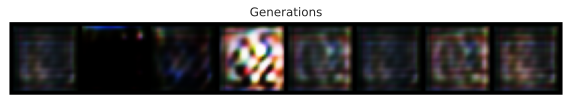

Epoch: 61, discrimiantor fake error: 0.0559, discriminator real acc: 0.953
Epoch: 62, discrimiantor fake error: 0.0431, discriminator real acc: 0.964
Epoch: 63, discrimiantor fake error: 0.0528, discriminator real acc: 0.953
Epoch: 64, discrimiantor fake error: 0.0545, discriminator real acc: 0.954
Epoch: 65, discrimiantor fake error: 0.0488, discriminator real acc: 0.958
Epoch: 66, discrimiantor fake error: 0.0518, discriminator real acc: 0.953
Epoch: 67, discrimiantor fake error: 0.0696, discriminator real acc: 0.944
Epoch: 68, discrimiantor fake error: 0.0513, discriminator real acc: 0.951
Epoch: 69, discrimiantor fake error: 0.0528, discriminator real acc: 0.938
Epoch: 70, discrimiantor fake error: 0.0397, discriminator real acc: 0.967


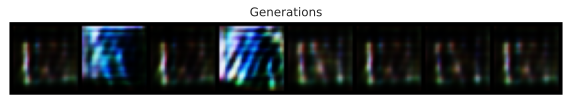

Epoch: 71, discrimiantor fake error: 0.0428, discriminator real acc: 0.971
Epoch: 72, discrimiantor fake error: 0.0456, discriminator real acc: 0.951
Epoch: 73, discrimiantor fake error: 0.0434, discriminator real acc: 0.955
Epoch: 74, discrimiantor fake error: 0.0359, discriminator real acc: 0.966
Epoch: 75, discrimiantor fake error: 0.0522, discriminator real acc: 0.941
Epoch: 76, discrimiantor fake error: 0.0359, discriminator real acc: 0.96
Epoch: 77, discrimiantor fake error: 0.0511, discriminator real acc: 0.949
Epoch: 78, discrimiantor fake error: 0.047, discriminator real acc: 0.953
Epoch: 79, discrimiantor fake error: 0.0326, discriminator real acc: 0.97
Epoch: 80, discrimiantor fake error: 0.0263, discriminator real acc: 0.976


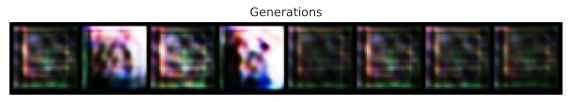

Epoch: 81, discrimiantor fake error: 0.043, discriminator real acc: 0.958
Epoch: 82, discrimiantor fake error: 0.051, discriminator real acc: 0.949
Epoch: 83, discrimiantor fake error: 0.0531, discriminator real acc: 0.947
Epoch: 84, discrimiantor fake error: 0.0335, discriminator real acc: 0.973
Epoch: 85, discrimiantor fake error: 0.0402, discriminator real acc: 0.962
Epoch: 86, discrimiantor fake error: 0.0425, discriminator real acc: 0.959
Epoch: 87, discrimiantor fake error: 0.0485, discriminator real acc: 0.948
Epoch: 88, discrimiantor fake error: 0.0383, discriminator real acc: 0.968
Epoch: 89, discrimiantor fake error: 0.0484, discriminator real acc: 0.951
Epoch: 90, discrimiantor fake error: 0.0494, discriminator real acc: 0.956


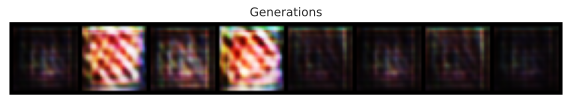

Epoch: 91, discrimiantor fake error: 0.0716, discriminator real acc: 0.935
Epoch: 92, discrimiantor fake error: 0.0376, discriminator real acc: 0.974
Epoch: 93, discrimiantor fake error: 0.0627, discriminator real acc: 0.95
Epoch: 94, discrimiantor fake error: 0.0496, discriminator real acc: 0.951
Epoch: 95, discrimiantor fake error: 0.069, discriminator real acc: 0.929
Epoch: 96, discrimiantor fake error: 0.0568, discriminator real acc: 0.944
Epoch: 97, discrimiantor fake error: 0.0589, discriminator real acc: 0.943
Epoch: 98, discrimiantor fake error: 0.0738, discriminator real acc: 0.93
Epoch: 99, discrimiantor fake error: 0.0671, discriminator real acc: 0.937
Epoch: 100, discrimiantor fake error: 0.0911, discriminator real acc: 0.912


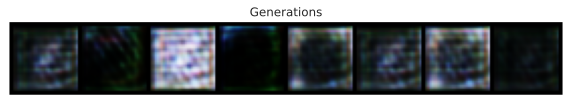

Epoch: 101, discrimiantor fake error: 0.0533, discriminator real acc: 0.952
Epoch: 102, discrimiantor fake error: 0.0464, discriminator real acc: 0.961
Epoch: 103, discrimiantor fake error: 0.0573, discriminator real acc: 0.936
Epoch: 104, discrimiantor fake error: 0.048, discriminator real acc: 0.953
Epoch: 105, discrimiantor fake error: 0.0693, discriminator real acc: 0.93
Epoch: 106, discrimiantor fake error: 0.0703, discriminator real acc: 0.93
Epoch: 107, discrimiantor fake error: 0.0454, discriminator real acc: 0.957
Epoch: 108, discrimiantor fake error: 0.052, discriminator real acc: 0.953
Epoch: 109, discrimiantor fake error: 0.0734, discriminator real acc: 0.924
Epoch: 110, discrimiantor fake error: 0.0659, discriminator real acc: 0.936


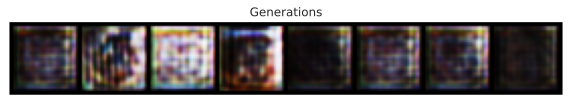

Epoch: 111, discrimiantor fake error: 0.0684, discriminator real acc: 0.921
Epoch: 112, discrimiantor fake error: 0.058, discriminator real acc: 0.945
Epoch: 113, discrimiantor fake error: 0.0506, discriminator real acc: 0.947
Epoch: 114, discrimiantor fake error: 0.0617, discriminator real acc: 0.94
Epoch: 115, discrimiantor fake error: 0.0696, discriminator real acc: 0.928
Epoch: 116, discrimiantor fake error: 0.0669, discriminator real acc: 0.935
Epoch: 117, discrimiantor fake error: 0.0553, discriminator real acc: 0.949
Epoch: 118, discrimiantor fake error: 0.0556, discriminator real acc: 0.946
Epoch: 119, discrimiantor fake error: 0.0419, discriminator real acc: 0.961
Epoch: 120, discrimiantor fake error: 0.0498, discriminator real acc: 0.954


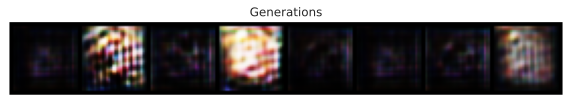

Epoch: 121, discrimiantor fake error: 0.0453, discriminator real acc: 0.964
Epoch: 122, discrimiantor fake error: 0.0526, discriminator real acc: 0.952
Epoch: 123, discrimiantor fake error: 0.0572, discriminator real acc: 0.944
Epoch: 124, discrimiantor fake error: 0.0572, discriminator real acc: 0.943
Epoch: 125, discrimiantor fake error: 0.0466, discriminator real acc: 0.954
Epoch: 126, discrimiantor fake error: 0.0496, discriminator real acc: 0.952
Epoch: 127, discrimiantor fake error: 0.0423, discriminator real acc: 0.963
Epoch: 128, discrimiantor fake error: 0.052, discriminator real acc: 0.95
Epoch: 129, discrimiantor fake error: 0.0714, discriminator real acc: 0.924
Epoch: 130, discrimiantor fake error: 0.05, discriminator real acc: 0.95


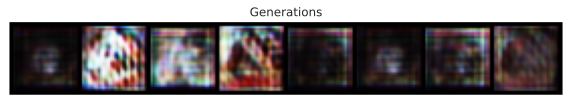

Epoch: 131, discrimiantor fake error: 0.0562, discriminator real acc: 0.942
Epoch: 132, discrimiantor fake error: 0.0486, discriminator real acc: 0.955
Epoch: 133, discrimiantor fake error: 0.0508, discriminator real acc: 0.95
Epoch: 134, discrimiantor fake error: 0.0486, discriminator real acc: 0.953
Epoch: 135, discrimiantor fake error: 0.0572, discriminator real acc: 0.944
Epoch: 136, discrimiantor fake error: 0.0438, discriminator real acc: 0.958
Epoch: 137, discrimiantor fake error: 0.0581, discriminator real acc: 0.947
Epoch: 138, discrimiantor fake error: 0.0553, discriminator real acc: 0.95
Epoch: 139, discrimiantor fake error: 0.0565, discriminator real acc: 0.943
Epoch: 140, discrimiantor fake error: 0.0418, discriminator real acc: 0.958


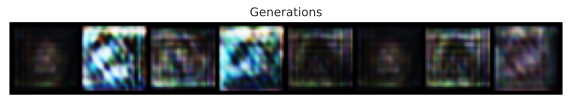

Epoch: 141, discrimiantor fake error: 0.0471, discriminator real acc: 0.954
Epoch: 142, discrimiantor fake error: 0.0407, discriminator real acc: 0.962
Epoch: 143, discrimiantor fake error: 0.0521, discriminator real acc: 0.946
Epoch: 144, discrimiantor fake error: 0.0464, discriminator real acc: 0.955
Epoch: 145, discrimiantor fake error: 0.0506, discriminator real acc: 0.95
Epoch: 146, discrimiantor fake error: 0.0406, discriminator real acc: 0.964
Epoch: 147, discrimiantor fake error: 0.0467, discriminator real acc: 0.956
Epoch: 148, discrimiantor fake error: 0.0442, discriminator real acc: 0.959
Epoch: 149, discrimiantor fake error: 0.0337, discriminator real acc: 0.968
Epoch: 150, discrimiantor fake error: 0.0294, discriminator real acc: 0.973


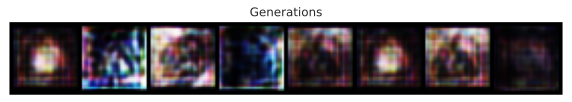

Epoch: 151, discrimiantor fake error: 0.0459, discriminator real acc: 0.953
Epoch: 152, discrimiantor fake error: 0.0537, discriminator real acc: 0.946
Epoch: 153, discrimiantor fake error: 0.0346, discriminator real acc: 0.965
Epoch: 154, discrimiantor fake error: 0.0474, discriminator real acc: 0.953
Epoch: 155, discrimiantor fake error: 0.0422, discriminator real acc: 0.957
Epoch: 156, discrimiantor fake error: 0.0406, discriminator real acc: 0.96
Epoch: 157, discrimiantor fake error: 0.043, discriminator real acc: 0.954
Epoch: 158, discrimiantor fake error: 0.0468, discriminator real acc: 0.955
Epoch: 159, discrimiantor fake error: 0.0552, discriminator real acc: 0.939
Epoch: 160, discrimiantor fake error: 0.0467, discriminator real acc: 0.951


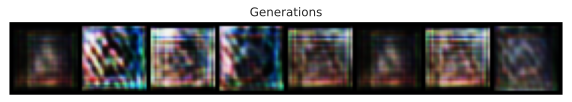

Epoch: 161, discrimiantor fake error: 0.0492, discriminator real acc: 0.951
Epoch: 162, discrimiantor fake error: 0.0432, discriminator real acc: 0.958
Epoch: 163, discrimiantor fake error: 0.05, discriminator real acc: 0.95
Epoch: 164, discrimiantor fake error: 0.0494, discriminator real acc: 0.949
Epoch: 165, discrimiantor fake error: 0.0524, discriminator real acc: 0.946
Epoch: 166, discrimiantor fake error: 0.0499, discriminator real acc: 0.946
Epoch: 167, discrimiantor fake error: 0.0453, discriminator real acc: 0.953
Epoch: 168, discrimiantor fake error: 0.0454, discriminator real acc: 0.957
Epoch: 169, discrimiantor fake error: 0.0479, discriminator real acc: 0.953
Epoch: 170, discrimiantor fake error: 0.0444, discriminator real acc: 0.958


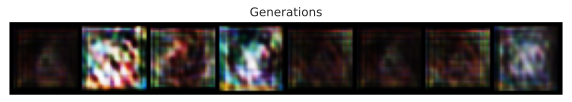

Epoch: 171, discrimiantor fake error: 0.0413, discriminator real acc: 0.964
Epoch: 172, discrimiantor fake error: 0.053, discriminator real acc: 0.948
Epoch: 173, discrimiantor fake error: 0.0547, discriminator real acc: 0.951
Epoch: 174, discrimiantor fake error: 0.0394, discriminator real acc: 0.963
Epoch: 175, discrimiantor fake error: 0.0402, discriminator real acc: 0.962
Epoch: 176, discrimiantor fake error: 0.0297, discriminator real acc: 0.97
Epoch: 177, discrimiantor fake error: 0.0279, discriminator real acc: 0.976
Epoch: 178, discrimiantor fake error: 0.0362, discriminator real acc: 0.966
Epoch: 179, discrimiantor fake error: 0.0518, discriminator real acc: 0.949
Epoch: 180, discrimiantor fake error: 0.0472, discriminator real acc: 0.951


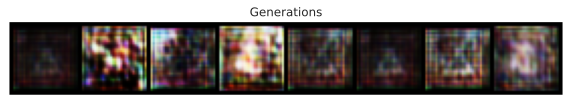

Epoch: 181, discrimiantor fake error: 0.0496, discriminator real acc: 0.952
Epoch: 182, discrimiantor fake error: 0.0402, discriminator real acc: 0.958
Epoch: 183, discrimiantor fake error: 0.0494, discriminator real acc: 0.949
Epoch: 184, discrimiantor fake error: 0.0502, discriminator real acc: 0.949
Epoch: 185, discrimiantor fake error: 0.049, discriminator real acc: 0.953
Epoch: 186, discrimiantor fake error: 0.0393, discriminator real acc: 0.961
Epoch: 187, discrimiantor fake error: 0.0496, discriminator real acc: 0.95
Epoch: 188, discrimiantor fake error: 0.046, discriminator real acc: 0.954
Epoch: 189, discrimiantor fake error: 0.052, discriminator real acc: 0.945
Epoch: 190, discrimiantor fake error: 0.0417, discriminator real acc: 0.958


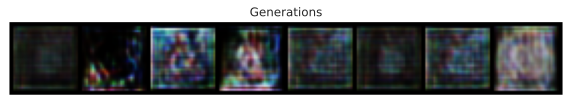

Epoch: 191, discrimiantor fake error: 0.0427, discriminator real acc: 0.956
Epoch: 192, discrimiantor fake error: 0.0407, discriminator real acc: 0.958
Epoch: 193, discrimiantor fake error: 0.0292, discriminator real acc: 0.97
Epoch: 194, discrimiantor fake error: 0.0275, discriminator real acc: 0.972
Epoch: 195, discrimiantor fake error: 0.0369, discriminator real acc: 0.964
Epoch: 196, discrimiantor fake error: 0.0435, discriminator real acc: 0.96
Epoch: 197, discrimiantor fake error: 0.0494, discriminator real acc: 0.951
Epoch: 198, discrimiantor fake error: 0.0429, discriminator real acc: 0.954
Epoch: 199, discrimiantor fake error: 0.0465, discriminator real acc: 0.952
Epoch: 200, discrimiantor fake error: 0.0532, discriminator real acc: 0.945


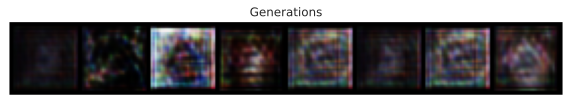

Epoch: 201, discrimiantor fake error: 0.0447, discriminator real acc: 0.953
Epoch: 202, discrimiantor fake error: 0.0405, discriminator real acc: 0.959
Epoch: 203, discrimiantor fake error: 0.0424, discriminator real acc: 0.961
Epoch: 204, discrimiantor fake error: 0.0474, discriminator real acc: 0.951
Epoch: 205, discrimiantor fake error: 0.0405, discriminator real acc: 0.962
Epoch: 206, discrimiantor fake error: 0.0305, discriminator real acc: 0.97
Epoch: 207, discrimiantor fake error: 0.0313, discriminator real acc: 0.969
Epoch: 208, discrimiantor fake error: 0.0425, discriminator real acc: 0.962
Epoch: 209, discrimiantor fake error: 0.0366, discriminator real acc: 0.966
Epoch: 210, discrimiantor fake error: 0.0305, discriminator real acc: 0.972


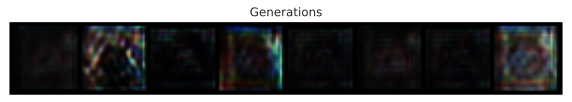

Epoch: 211, discrimiantor fake error: 0.0292, discriminator real acc: 0.976
Epoch: 212, discrimiantor fake error: 0.0244, discriminator real acc: 0.978
Epoch: 213, discrimiantor fake error: 0.047, discriminator real acc: 0.952
Epoch: 214, discrimiantor fake error: 0.0429, discriminator real acc: 0.956
Epoch: 215, discrimiantor fake error: 0.0382, discriminator real acc: 0.959
Epoch: 216, discrimiantor fake error: 0.037, discriminator real acc: 0.966
Epoch: 217, discrimiantor fake error: 0.0315, discriminator real acc: 0.968
Epoch: 218, discrimiantor fake error: 0.0409, discriminator real acc: 0.96
Epoch: 219, discrimiantor fake error: 0.0398, discriminator real acc: 0.96
Epoch: 220, discrimiantor fake error: 0.0303, discriminator real acc: 0.971


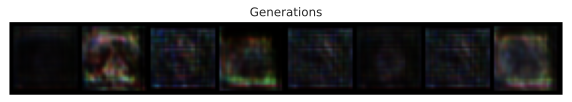

Epoch: 221, discrimiantor fake error: 0.049, discriminator real acc: 0.949
Epoch: 222, discrimiantor fake error: 0.0525, discriminator real acc: 0.95
Epoch: 223, discrimiantor fake error: 0.0447, discriminator real acc: 0.956
Epoch: 224, discrimiantor fake error: 0.0432, discriminator real acc: 0.959
Epoch: 225, discrimiantor fake error: 0.0499, discriminator real acc: 0.953
Epoch: 226, discrimiantor fake error: 0.0535, discriminator real acc: 0.946
Epoch: 227, discrimiantor fake error: 0.0369, discriminator real acc: 0.963
Epoch: 228, discrimiantor fake error: 0.0446, discriminator real acc: 0.957
Epoch: 229, discrimiantor fake error: 0.0583, discriminator real acc: 0.944
Epoch: 230, discrimiantor fake error: 0.0507, discriminator real acc: 0.949


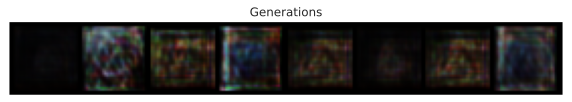

Epoch: 231, discrimiantor fake error: 0.0414, discriminator real acc: 0.959
Epoch: 232, discrimiantor fake error: 0.0471, discriminator real acc: 0.952
Epoch: 233, discrimiantor fake error: 0.0407, discriminator real acc: 0.959
Epoch: 234, discrimiantor fake error: 0.047, discriminator real acc: 0.952
Epoch: 235, discrimiantor fake error: 0.0382, discriminator real acc: 0.962
Epoch: 236, discrimiantor fake error: 0.0468, discriminator real acc: 0.957
Epoch: 237, discrimiantor fake error: 0.0499, discriminator real acc: 0.946
Epoch: 238, discrimiantor fake error: 0.0455, discriminator real acc: 0.957
Epoch: 239, discrimiantor fake error: 0.0524, discriminator real acc: 0.95
Epoch: 240, discrimiantor fake error: 0.0437, discriminator real acc: 0.963


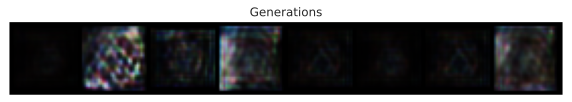

Epoch: 241, discrimiantor fake error: 0.0497, discriminator real acc: 0.952
Epoch: 242, discrimiantor fake error: 0.0466, discriminator real acc: 0.953
Epoch: 243, discrimiantor fake error: 0.04, discriminator real acc: 0.964
Epoch: 244, discrimiantor fake error: 0.0349, discriminator real acc: 0.966
Epoch: 245, discrimiantor fake error: 0.0392, discriminator real acc: 0.959
Epoch: 246, discrimiantor fake error: 0.0444, discriminator real acc: 0.956
Epoch: 247, discrimiantor fake error: 0.0375, discriminator real acc: 0.964
Epoch: 248, discrimiantor fake error: 0.0403, discriminator real acc: 0.961
Epoch: 249, discrimiantor fake error: 0.044, discriminator real acc: 0.954
Epoch: 250, discrimiantor fake error: 0.0331, discriminator real acc: 0.967


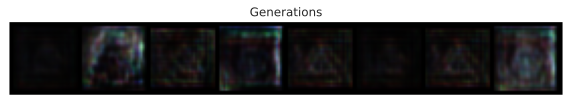

Epoch: 251, discrimiantor fake error: 0.0352, discriminator real acc: 0.964
Epoch: 252, discrimiantor fake error: 0.0398, discriminator real acc: 0.961
Epoch: 253, discrimiantor fake error: 0.0373, discriminator real acc: 0.96
Epoch: 254, discrimiantor fake error: 0.045, discriminator real acc: 0.952
Epoch: 255, discrimiantor fake error: 0.0335, discriminator real acc: 0.967
Epoch: 256, discrimiantor fake error: 0.0393, discriminator real acc: 0.962
Epoch: 257, discrimiantor fake error: 0.0333, discriminator real acc: 0.968
Epoch: 258, discrimiantor fake error: 0.0401, discriminator real acc: 0.961
Epoch: 259, discrimiantor fake error: 0.0434, discriminator real acc: 0.957
Epoch: 260, discrimiantor fake error: 0.0415, discriminator real acc: 0.959


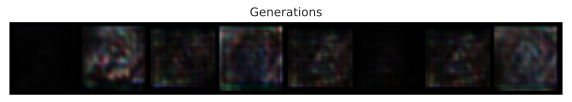

Epoch: 261, discrimiantor fake error: 0.0367, discriminator real acc: 0.963
Epoch: 262, discrimiantor fake error: 0.0395, discriminator real acc: 0.961
Epoch: 263, discrimiantor fake error: 0.0468, discriminator real acc: 0.954
Epoch: 264, discrimiantor fake error: 0.0421, discriminator real acc: 0.957
Epoch: 265, discrimiantor fake error: 0.0438, discriminator real acc: 0.961
Epoch: 266, discrimiantor fake error: 0.0365, discriminator real acc: 0.968
Epoch: 267, discrimiantor fake error: 0.0382, discriminator real acc: 0.962
Epoch: 268, discrimiantor fake error: 0.0379, discriminator real acc: 0.962
Epoch: 269, discrimiantor fake error: 0.0455, discriminator real acc: 0.953
Epoch: 270, discrimiantor fake error: 0.0392, discriminator real acc: 0.961


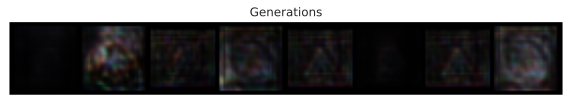

Epoch: 271, discrimiantor fake error: 0.0416, discriminator real acc: 0.957
Epoch: 272, discrimiantor fake error: 0.0472, discriminator real acc: 0.956
Epoch: 273, discrimiantor fake error: 0.0435, discriminator real acc: 0.96
Epoch: 274, discrimiantor fake error: 0.0332, discriminator real acc: 0.97
Epoch: 275, discrimiantor fake error: 0.0345, discriminator real acc: 0.968
Epoch: 276, discrimiantor fake error: 0.0321, discriminator real acc: 0.969
Epoch: 277, discrimiantor fake error: 0.0357, discriminator real acc: 0.965
Epoch: 278, discrimiantor fake error: 0.0305, discriminator real acc: 0.968
Epoch: 279, discrimiantor fake error: 0.0314, discriminator real acc: 0.968
Epoch: 280, discrimiantor fake error: 0.0292, discriminator real acc: 0.972


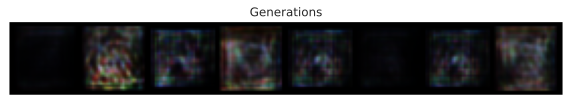

Epoch: 281, discrimiantor fake error: 0.0262, discriminator real acc: 0.976
Epoch: 282, discrimiantor fake error: 0.0316, discriminator real acc: 0.969
Epoch: 283, discrimiantor fake error: 0.0401, discriminator real acc: 0.959
Epoch: 284, discrimiantor fake error: 0.0368, discriminator real acc: 0.961
Epoch: 285, discrimiantor fake error: 0.0335, discriminator real acc: 0.965
Epoch: 286, discrimiantor fake error: 0.0287, discriminator real acc: 0.975
Epoch: 287, discrimiantor fake error: 0.0283, discriminator real acc: 0.975
Epoch: 288, discrimiantor fake error: 0.0363, discriminator real acc: 0.965
Epoch: 289, discrimiantor fake error: 0.0218, discriminator real acc: 0.98
Epoch: 290, discrimiantor fake error: 0.0319, discriminator real acc: 0.966


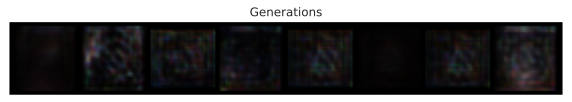

Epoch: 291, discrimiantor fake error: 0.0373, discriminator real acc: 0.96
Epoch: 292, discrimiantor fake error: 0.0336, discriminator real acc: 0.966
Epoch: 293, discrimiantor fake error: 0.0296, discriminator real acc: 0.969
Epoch: 294, discrimiantor fake error: 0.0331, discriminator real acc: 0.965
Epoch: 295, discrimiantor fake error: 0.037, discriminator real acc: 0.964
Epoch: 296, discrimiantor fake error: 0.027, discriminator real acc: 0.978
Epoch: 297, discrimiantor fake error: 0.0222, discriminator real acc: 0.975
Epoch: 298, discrimiantor fake error: 0.0224, discriminator real acc: 0.978
Epoch: 299, discrimiantor fake error: 0.0339, discriminator real acc: 0.966
Epoch: 300, discrimiantor fake error: 0.0296, discriminator real acc: 0.971


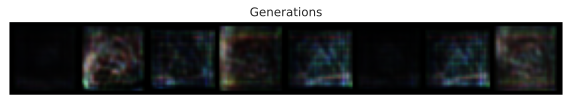

Epoch: 301, discrimiantor fake error: 0.022, discriminator real acc: 0.979
Epoch: 302, discrimiantor fake error: 0.0257, discriminator real acc: 0.975
Epoch: 303, discrimiantor fake error: 0.0231, discriminator real acc: 0.978
Epoch: 304, discrimiantor fake error: 0.03, discriminator real acc: 0.972
Epoch: 305, discrimiantor fake error: 0.0305, discriminator real acc: 0.971
Epoch: 306, discrimiantor fake error: 0.0348, discriminator real acc: 0.965
Epoch: 307, discrimiantor fake error: 0.0313, discriminator real acc: 0.97
Epoch: 308, discrimiantor fake error: 0.0374, discriminator real acc: 0.963
Epoch: 309, discrimiantor fake error: 0.0388, discriminator real acc: 0.96
Epoch: 310, discrimiantor fake error: 0.0442, discriminator real acc: 0.951


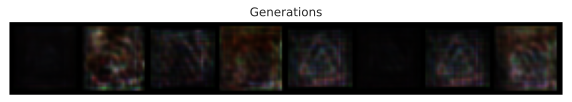

Epoch: 311, discrimiantor fake error: 0.0296, discriminator real acc: 0.969
Epoch: 312, discrimiantor fake error: 0.0298, discriminator real acc: 0.972
Epoch: 313, discrimiantor fake error: 0.0345, discriminator real acc: 0.968
Epoch: 314, discrimiantor fake error: 0.0321, discriminator real acc: 0.969
Epoch: 315, discrimiantor fake error: 0.0313, discriminator real acc: 0.97
Epoch: 316, discrimiantor fake error: 0.0316, discriminator real acc: 0.971
Epoch: 317, discrimiantor fake error: 0.0304, discriminator real acc: 0.972
Epoch: 318, discrimiantor fake error: 0.0241, discriminator real acc: 0.978
Epoch: 319, discrimiantor fake error: 0.0357, discriminator real acc: 0.962


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fca3c793520>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fca3c793520>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

RuntimeError: Pin memory thread exited unexpectedly

ConnectionResetError: [Errno 104] Connection reset by peer

In [163]:
for epoch in range(num_epochs):
    # For each batch in the dataloader
    discriminator_fake_acc = []
    discriminator_real_acc = []
    for i, data in enumerate(train_loader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        discriminator_optimizer.zero_grad()
        # Format batch
        classes_encoded = get_classes_encoded(train_classes, data[1], encoding).to(device)
        real_images = data[0].to(device)

        b_size = real_images.size(0)
        label = torch.ones((b_size,), dtype=torch.float, device=device) # Setting labels for real images
        # Forward pass real batch through D
        output = discriminator(real_images, classes_encoded).view(-1)
        # Calculate loss on all-real batch
        error_discriminator_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        discriminator_real_acc.append(output.mean().item())

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, latent_dim,device=device)
        fake_images = generator(noise, classes_encoded)
        label_fake = torch.zeros((b_size,), dtype=torch.float, device=device)
        output = discriminator(fake_images.detach(), classes_encoded).view(-1)
        error_discriminator_fake = criterion(output, label_fake)
        discriminator_fake_acc.append(output.mean().item())
        error_discriminator = error_discriminator_real + error_discriminator_fake
        error_discriminator.backward()
        discriminator_optimizer.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        generator_optimizer.zero_grad()
        label = torch.ones((b_size,), dtype=torch.float, device=device)  # fake labels are real for generator cost

        output = discriminator(fake_images, classes_encoded).view(-1)
        error_generator = criterion(output, label)
        error_generator.backward()
        D_G_z2 = output.mean().item()
        generator_optimizer.step()

    
        G_losses.append(error_generator.item())
        D_losses.append(error_discriminator.item())
        DF_acc.append(np.mean(discriminator_fake_acc))
        DR_acc.append(np.mean(discriminator_real_acc))

    print(f"Epoch: {epoch}, discrimiantor fake error: {DF_acc[-1]:.3}, discriminator real acc: {DR_acc[-1]:.3}")
    generator_scheduler.step()
    discriminator_scheduler.step()
   
    if epoch % 10 == 0:
        classes_encoded_small = get_classes_encoded(train_classes, [torch.tensor(1), torch.tensor(2),torch.tensor(3),torch.tensor(16),torch.tensor(23),\
                                                                torch.tensor(34),torch.tensor(8),torch.tensor(9)], encoding).to(device)
        with torch.no_grad():
            fake = generator(fixed_noise, classes_encoded_small).detach().cpu()
        grid = torchvision.utils.make_grid(fake)
        grid = grid.permute(1, 2, 0)
        plt.figure(figsize=(10,10))
        plt.title(f"Generations")
        plt.imshow(grid)
        plt.axis('off')
        plt.show()

In [164]:
def get_train_images(num):
    return torch.stack([train_data[i][0] for i in range(10,10+num)], dim=0)

In [165]:
input_imgs = get_train_images(8)

In [166]:
def generate_images(model, n_imgs, device):
    # Generate images
    model.eval()
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=n_imgs, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
    images, labels = next(iter(train_loader))
    # classes_to_generate = torch.concat((rmd_to_genrate, encoding[:n_imgs]), dim=1).to(device)
    # print(classes_to_generate)
    fixed_noise = torch.randn(n_imgs, 32 ,device=device).to(device)
    # rmd_to_genrate = torch.randn([12, 32]).to(device)
    encoded_classes = get_classes_encoded(train_classes, labels, encoding).to(device)
    with torch.no_grad():
        generated_imgs = model(fixed_noise, encoded_classes).to(device)
    generated_imgs = generated_imgs.cpu()


    grid = torchvision.utils.make_grid(generated_imgs, nrow=4, normalize=False, value_range=(-1,1))
    grid = grid.permute(1, 2, 0)
    if len(input_imgs) == 4:
        plt.figure(figsize=(10,10))
    else:
        plt.figure(figsize=(15,10))
    plt.title(f"Generations")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

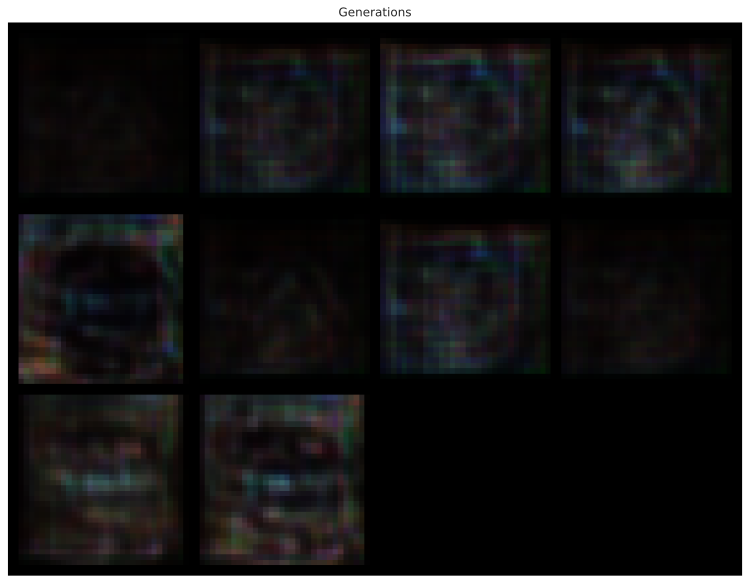

In [172]:
generate_images(generator, 10, device)

In [169]:
# torch.save(generator.state_dict(), 'generatorBig.pt')
# torch.save(generator.state_dict(), 'discriminatorBig.pt')

In [173]:
def im_save(img, path):
    #img = img / 2 + 0.5     # unnormalize
    save_image(img, path)

def evaluate_model(model, train_data, encoding: list, train_classes, n_imgs):
    model.eval()
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=n_imgs, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
    images, labels = next(iter(train_loader))
    fixed_noise = torch.randn(n_imgs, 32 ,device=device).to(device)
    encoded_classes = get_classes_encoded(train_classes, labels, encoding).to(device)
    with torch.no_grad():
        generated_imgs = model(fixed_noise, encoded_classes).to(device)
    generated_imgs = generated_imgs.cpu()
    
    
    for j, img in enumerate(generated_imgs):
        im_save(img, f'gen_eval/img{j}.jpg')
    for j, img in enumerate(images):
        im_save(img, f'real_eval/img{j}.jpg')
    paths = ['real_eval', 'gen_eval']
    return fid_score.calculate_fid_given_paths(paths, batch_size=200, device='cuda', dims=2048)


In [174]:
evaluate_model(generator, train_data, encoding, train_classes, 256)

274.66235541982803